In [15]:
import argparse
from functools import partial
from glob import glob
from joblib import Parallel, delayed
import json
from nipype.caching import Memory
from nipype.interfaces import fsl
from nilearn import datasets, image, plotting
from nilearn.regions import RegionExtractor
from nilearn.decomposition import CanICA
import numpy as np
import os
from os import makedirs, path
import pandas as pd
import pickle
import re
import shutil
import sys

from utils.utils import (concat_and_smooth, create_neural_feature_mat, create_projections_df)
from utils.plot_utils import plot_2ndlevel_maps

### Parse Arguments
These are not needed for the jupyter notebook, but are used after conversion to a script for production

- conversion command:
  - jupyter nbconvert --to script --execute 2ndlevel_analysis.ipynb

In [132]:
parser = argparse.ArgumentParser(description='fMRI Analysis Entrypoint Script.')
parser.add_argument('-derivatives_dir')
parser.add_argument('-working_dir', default=None)
parser.add_argument('--tasks', nargs="+")
parser.add_argument('--n_procs', default=4, type=int)
parser.add_argument('--num_perm', default=1000, type=int, help="Passed to fsl.randomize")
parser.add_argument('--ignore_rt', action='store_false')

if '-derivatives_dir' in sys.argv or '-h' in sys.argv:
    args = parser.parse_args()
else:
    args = parser.parse_args([])
    args.derivatives_dir='/data/derivatives'

In [134]:
derivatives_dir = args.derivatives_dir
fmriprep_dir = path.join(derivatives_dir, 'fmriprep', 'fmriprep')
first_level_dir = path.join(derivatives_dir, '1stlevel')
second_level_dir = path.join(derivatives_dir,'2ndlevel')
if args.working_dir is None:
    working_dir = path.join(derivatives_dir, '2ndlevel_workingdir')
else:
    working_dir = path.join(args.working_dir, '2ndlevel_workingdir')
makedirs(working_dir, exist_ok=True)
    
tasks = ['ANT', 'CCTHot', 'discountFix',
         'DPX', 'motorSelectiveStop',
         'stopSignal', 'stroop', 
         'surveyMedley', 'twoByTwo', 'WATT3']
if args.tasks:
    tasks = args.tasks
regress_rt = args.ignore_rt
model = 'model-rt' if regress_rt == True else 'model-nort'

### Create group Mask

In [48]:
def create_group_mask(mask_loc, fmriprep_dir, threshold=.8, verbose=True):
    if verbose:
        print('Creating Group mask...')
    makedirs(path.dirname(mask_loc), exist_ok=True)
    brainmasks = glob(path.join(fmriprep_dir,'sub-s???',
                               '*','func','*MNI152NLin2009cAsym_brainmask*'))
    mean_mask = image.mean_img(brainmasks)
    group_mask = image.math_img("a>=%s" % str(threshold), a=mean_mask)
    group_mask.to_filename(mask_loc)
    if verbose:
        print('Finished creating group mask')

In [45]:
# create mask over all tasks
# create 95% brain mask
mask_loc = path.join(second_level_dir, 'group_mask.nii.gz')
if path.exists(mask_loc) == False:
    create_group_mask(mask_loc, fmriprep_dir, .8)

In [ ]:
"""
# save subject names in order on 1st iteration
if i==0:
    subj_ids = [re.search('s[0-9][0-9][0-9]', file).group(0) 
                    for file in map_files]
    # see if these maps have been run before, and, if so, skip
    try:
        previous_ids = json.load(open(join(data_dir,
                                           task,
                                           'subj_ids.json'), 'r'))
        if previous_ids == subj_ids:
            print('No new subjects added since last ran, skipping...')
            break
        else:
            json.dump(subj_ids, open(join(task_dir, 'subj_ids.json'),'w'))
    except FileNotFoundError:
        json.dump(subj_ids, open(join(task_dir, 'subj_ids.json'),'w'))
"""

### Create Group Maps

In [159]:
def get_contrast_names(subjectinfo_path):
    try:
        contrasts = pickle.load(open(subjectinfo_path, 'rb')).contrasts
        contrast_names = [i[0] for i in contrasts]
    except IndexError:
        print('No subjectinfo found for %s_%s' % (task, model))
        contrast_names = None
    return contrast_names

def save_smooth_maps(task, model=model, smoothness=4.4,
                     second_level_dir=second_level_dir,
                     first_level_dir=first_level_dir,
                     mask_loc=mask_loc,
                     verbose=True):
    task_dir = path.join(second_level_dir, task, model, 'wf-contrast')
    makedirs(task_dir, exist_ok=True)
    # get contrasts
    subjectinfo_paths = glob(path.join(first_level_dir, '*', task, model, 
                                       'wf-contrast','subjectinfo.pkl'))
    contrast_names = get_contrast_names(subjectinfo_paths[0])
    if contrast_names is None:
        return
    if verbose: print('Creating %s group map' % task)
    for i, contrast_name in enumerate(contrast_names):
        if verbose: print('    Contrast: %s' % contrast_name)
        # load, smooth, and concatenate contrasts
        map_files = sorted(
            glob( path.join(first_level_dir, '*', task, model,
                            '*contrast', '*cope%s.nii.gz' % str(i + 1))))
        # if there are map files, create group map
        if len(map_files) > 1:
            smooth_copes = concat_and_smooth(map_files, smoothness=smoothness)
            copes_concat = image.concat_imgs(
                smooth_copes.values(), auto_resample=True)
            copes_loc = path.join(task_dir, "%s_copes.nii.gz" % contrast_name)
            copes_concat.to_filename(copes_loc)
            
def save_tmaps(task, model=model,
               second_level_dir=second_level_dir,
               mask_loc=mask_loc):
    task_dir = path.join(second_level_dir, task, model, 'wf-contrast')
    contrasts = glob(path.join(task_dir, '*copes.nii.gz'))
    for copes_loc in contrasts:
        contrast_name = path.basename(copes_loc).split('_copes')[0]
        # perform permutation test to assess significance
        mem = Memory(base_dir=working_dir)
        randomise = mem.cache(fsl.Randomise)
        randomise_results = randomise(
            in_file=copes_loc,
            mask=mask_loc,
            one_sample_group_mean=True,
            tfce=True,  # look at paper
            vox_p_values=True,
            num_perm=args.num_perm)
        # save results
        tfile_loc = path.join(task_dir, "%s_raw_tfile.nii" % contrast_name)
        tfile_corrected_loc = path.join(task_dir,
                                   "%s_corrected_tfile.nii" % contrast_name)
        raw_tfile = randomise_results.outputs.tstat_files[0]
        corrected_tfile = randomise_results.outputs.t_corrected_p_files[0]
        shutil.move(raw_tfile, tfile_loc)
        shutil.move(corrected_tfile, tfile_corrected_loc)

In [ ]:
# create partial function to pass to parallel
# smooth
contrast_smooth_parallel = partial(save_smooth_maps, model=model, smoothness=4.4, 
                                    second_level_dir=second_level_dir,
                                    first_level_dir=first_level_dir,
                                    mask_loc=mask_loc,
                                    verbose=False)
Parallel(n_jobs=args.n_procs)(delayed(contrast_smooth_parallel)(task) for task in tasks)
# then tmap
contrast_tmap_parallel = partial(save_tmaps, model=model, 
                                    second_level_dir=second_level_dir,
                                    mask_loc=mask_loc)
Parallel(n_jobs=args.n_procs)(delayed(contrast_tmap_parallel)(task) for task in tasks)

In [124]:
# % matplotlib inline
# task_contrasts = glob(path.join(second_level_dir, '*', 'model-rt', 'wf-contrast'))
# plot_2ndlevel_maps(task_contrasts[0], lookup='*raw*')
# plot_2ndlevel_maps(task_contrasts[1], lookup='*corrected*', threshold=.95)

### Use Parcellation to Project 1st-level Maps into low dimensional space

Projecting into a lower dimensional space allows the evaluation of whole-brain similarity analysis (clustering)

#### Get parcellations to use

In [604]:
def get_map_files(map_prefix='zstat',
                  first_leve_dir = first_level_dir,
                  tasks=tasks,
                  model=model,
                  selectors=None):
    map_files = {}
    for task in tasks: 
        subjectinfo_paths = sorted(glob(path.join(first_level_dir,'*', task, model, 'wf-contrast', 'subjectinfo.pkl')))
        if len(subjectinfo_paths)>0:
            contrast_names = get_contrast_names(subjectinfo_paths[0])
        else:
            continue # move to next iteration if no contrast files found
        if contrast_names is None:
            continue

        # select only a subset of contrasts (i.e.  get explicit contrasts, not vs rest)
        if selectors is None:
            selectors = ['-', 'network', 'response_time']
        for i, name in enumerate(contrast_names):
            if np.logical_or.reduce([sel in name for sel in selectors]):
                map_files[task+'_'+name] = sorted(glob(path.join(first_level_dir,'*', task, model, 'wf-contrast', 'zstat%s.nii.gz' % str(i+1))))
    return map_files

def get_ICA_parcellation(map_files,
                        n_comps=20,
                        mask_loc=mask_loc,
                        working_dir=working_dir,
                        smoothing=4.4,
                        file_name=''):
    group_mask = nibabel.load(mask_loc)
    ##  get components
    canica = CanICA(mask = group_mask, n_components=n_comps, 
                    smoothing_fwhm=smoothing, memory=path.join(working_dir, "nilearn_cache"), 
                    memory_level=2, threshold=3., 
                    verbose=10, random_state=0) # multi-level components modeling across subjects
    canica.fit(map_files)
    masker = canica.masker_
    components_img = masker.inverse_transform(canica.components_)
    components_img.to_filename(path.join(second_level_dir, 
                                        '%s_canica%s.nii.gz' 
                                        % (file_name, n_comps)))
    return components_img
    
def get_established_parcellation(parcellation="Harvard_Oxford", target_img=None):
    if parcellation == "Harvard_Oxford":
        data = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')
        parcel = nibabel.load(data['maps'])
        labels = data['labels'][1:] # first label is background
    if parcellation == "smith":
        data = datasets.fetch_atlas_smith_2009()['rsn70']
        parcel = nibabel.load(data)
        labels = range(parcel.shape[-1])
    if target_img:
        parcel = image.resample_to_img(parcel, target_img)
    return parcel, labels



In [525]:
map_files = get_map_files(map_prefix='zstat')
ICA_parcel = get_ICA_parcellation(map_files, 20, mask_loc, file_name='contrast')
harvard_parcel, harvard_labels = get_established_parcellation("Harvard_Oxford", target_img=map_files[0])
smith_parcel, smith_labels = get_established_parcellation("smith", target_img=map_files[0])

#### Use parcellation to create ROIs and calculate RDMs amongst contrasts

In [565]:
def get_ROI_from_parcel(parcel, ROI, threshold):
    # convert a probabilistic parcellation into an ROI mask
    roi_mask = harvard_parcel.get_data()[:,:,:,ROI]>threshold 
    roi_mask = image.new_img_like(harvard_parcel, roi_mask)
    return roi_mask


def extract_roi_vals(map_files, parcel, threshold, labels=None):
    """ Mask nifti images using a parcellation"""
    if type(mape_files) == dict:
        map_files = [item for sublist in map_files.values() for item in sublist]
    roi_vals = {}
    for roi_i in range(parcel.shape[-1]):
        roi_mask = get_ROI_from_parcel(parcel, roi_i, threshold)
        if labels:
            key = labels[roi_i]
        else:
            key = roi_i
        roi_vals[key] = nilearn.masking.apply_mask(map_files, roi_mask)
    return roi_vals

def get_RDMs(ROI_dict):
    # converts ROI dictionary of contrast X voxel values to RDMs
    RDMs = {}
    for key,val in ROI_dict.items():
        RDMs[key] = 1-np.corrcoef(val)
    return RDMs

In [548]:
harvard_contrasts = extract_roi_vals(map_files, harvard_parcel, 10, labels=harvard_labels)
RDMs = get_RDMs(harvard_contrasts, remove_mean=True)

Each ROI has an RDM reflecting its "representation" of cognitive faculties probed by these contrasts

In [567]:
# similarity of RDMs
keys = list(RDMs.keys())
vectorized_RDMs = np.vstack([RDMs[k].flatten() for k in keys])
RDM_of_RDMs = 1-np.corrcoef(vectorized_RDMs)
RDM_of_RDMs = pd.DataFrame(RDM_of_RDMs, index=keys, columns=keys)

/usr/local/miniconda/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/usr/local/miniconda/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


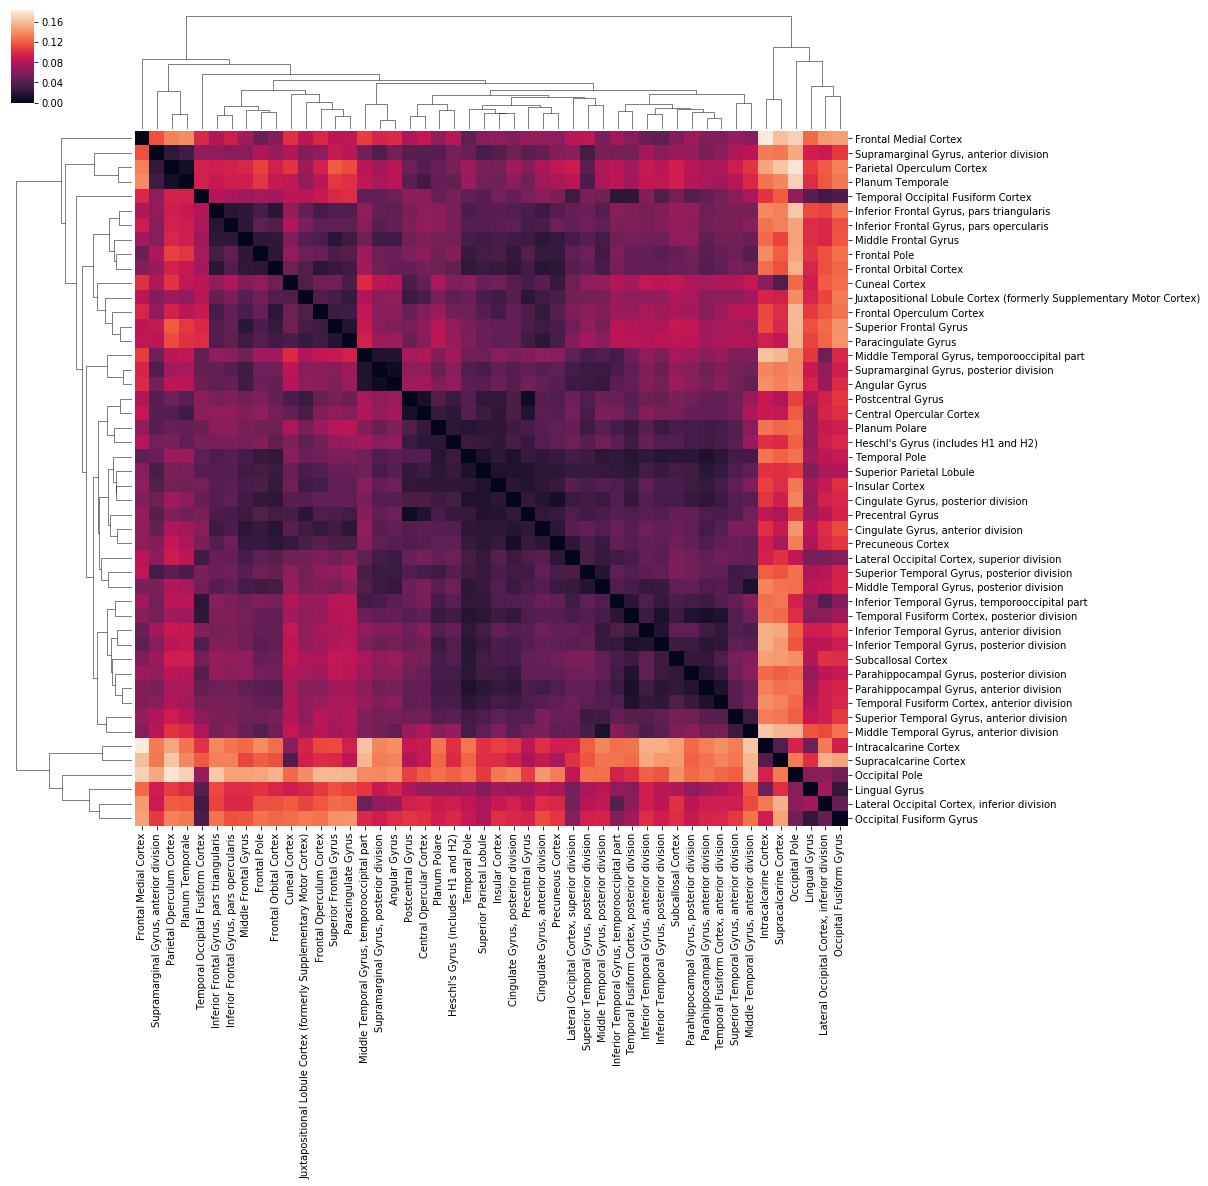

In [568]:
# visualize RDM of RDMs
sns.clustermap(RDM_of_RDMs, figsize=[15,15])

In [423]:
mean_harvard = {k: v.mean(1) for k,v in harvard_contrasts.items()}
out = project_contrast(map_files, harvard_parcel, mask_loc)

/usr/local/miniconda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:118: UserWarning: Incompatible cache in nilearn_cache/joblib: different version of nibabel. Deleting the cache. Put nilearn.CHECK_CACHE_VERSION to false to avoid this behavior.
  % cachedir)


In [440]:
b = np.vstack([mean_harvard[i] for i in range(1+max(mean_harvard.keys()))]).T

#### Apply parcellations

In [ ]:
"""
# ********************************************************
# Set up parcellation
# ********************************************************

#******************* Estimate parcellation from data ***********************
print('Creating ICA based parcellation')


# group map files by subject
subject_ids = np.unique([f.split(os.sep)[-2].split('_')[0] for f in map_files])
subject_map_files = []
for s in subject_ids:
    subject_map_files.append(image.concat_imgs([f for f in map_files if s in f]))






# ********************************************************
# Reduce dimensionality of contrasts
# ********************************************************
def split_index(projections_df):
    subj = [f.split('_')[0] for f in projections_df.index]
    contrast = ['_'.join(f.split('_')[1:]) for f in projections_df.index]
    projections_df.insert(0, 'subj', subj)
    projections_df.insert(1, 'contrast', contrast)
    
    
parcellation_files = [('smith70', smith_networks),
                      ('canica20', 
                       join(output_dir, 'canica20_explicit_contrasts.nii.gz')),
                      ('canica50', 
                       join(output_dir, 'canica50_explicit_contrasts.nii.gz')),
                       ('canica70', 
                       join(output_dir, 'canica70_explicit_contrasts.nii.gz'))
                       ]

for parcellation_name, parcellation_file in parcellation_files:
    projection_filey = join(output_dir, '%s_projection.json' % parcellation_name)
    mask_file = join(output_dir, 'group_mask.nii.gz')
    projections_df = create_projections_df(parcellation_file, mask_file, 
                                           data_dir, tasks, projection_filey)
    
    # create a subject x neural feature vector where each column is a component
    # for one contrast
    neural_feature_mat = create_neural_feature_mat(projections_df,
                                                   filename=join(output_dir, 
                                                        '%s_neural_features.json'  
                                                        % parcellation_name))
"""